In [1]:
import sys
sys.path.append("../LocalGraphClustering/")
import localgraphclustering as lgc
from localgraphclustering.find_clusters import semisupervised_learning_with_improve,semisupervised_learning
from collections import Counter,defaultdict
import numpy as np
import matplotlib.pyplot as plt

# Citeseer dataset

In [2]:
rptr = open("dataset/citeseer/citeseer.content","r")
lines = rptr.readlines()
rptr.close()

ids = {}
labels = {}
clusters = defaultdict(list)
nnodes = 0
for i,line in enumerate(lines):
    tmp = line.replace("\n","").split("\t")
    labels[i] = tmp[-1]
    ids[tmp[0]] = i
    nnodes += 1
    clusters[tmp[-1]].append(i)

rptr = open("dataset/citeseer/citeseer.cites","r")
lines = rptr.readlines()
rptr.close()

ei,ej = [],[]
for line in lines:
    tmp = line.replace("\n","").split("\t")
    if tmp[0] not in ids:
        ids[tmp[0]] = nnodes
        nnodes += 1
    if tmp[1] not in ids:
        ids[tmp[1]] = nnodes
        nnodes += 1
    ei.append(ids[tmp[0]])
    ej.append(ids[tmp[1]])

g = lgc.GraphLocal()
g.list_to_gl(ei,ej,[1.0]*len(ei))
g.connected_components()
largest_component= set(np.nonzero(g.components == Counter(g.components).most_common()[0][0])[0])
g_copy = g.largest_component()
clusters_copy = defaultdict(list)
nnodes = 0
for i in range(g._num_vertices):
    if i in largest_component:
        if i in labels:
            clusters_copy[labels[i]].append(nnodes)
        nnodes += 1

There are  438  connected components in the graph
There are  438  connected components in the graph


../LocalGraphClustering/localgraphclustering/GraphLocal.py:621: UserWarning:

The graph has multiple (438) components, using the largest with 2120 / 3327 nodes



## semi-supervised learning using subset of target cluster as seed nodes

In [3]:
kwargs_list = [{"method":"l1reg-rand",
                "alpha":0.1,
                "rho":1.0e-10,
                "normalize":False,
                "normalized_objective":False,
                "epsilon":1.0e-8,
                "iterations":100000,
                "cpp":True,
                "delta":0.0001,
                "ratio":ratio} for ratio in 0.01*np.array(range(5,26))]

In [4]:
records = semisupervised_learning(g_copy,clusters_copy,kwargs_list,nprocs=40,flowmethod="sl_weighted")

Finished 0/420 experiments.
Finished 10/420 experiments.
Finished 20/420 experiments.
Finished 30/420 experiments.
Finished 40/420 experiments.
Finished 50/420 experiments.
Finished 60/420 experiments.
Finished 70/420 experiments.
Finished 80/420 experiments.
Finished 90/420 experiments.
Finished 100/420 experiments.
Finished 110/420 experiments.
Finished 120/420 experiments.
Finished 130/420 experiments.
Finished 140/420 experiments.
Finished 150/420 experiments.
Finished 160/420 experiments.
Finished 170/420 experiments.
Finished 180/420 experiments.
Finished 190/420 experiments.
Finished 200/420 experiments.
Finished 210/420 experiments.
Finished 220/420 experiments.
Finished 230/420 experiments.
Finished 240/420 experiments.
Finished 250/420 experiments.
Finished 260/420 experiments.
Finished 270/420 experiments.
Finished 280/420 experiments.
Finished 290/420 experiments.
Finished 300/420 experiments.
Finished 310/420 experiments.
Finished 320/420 experiments.
Finished 330/420 expe

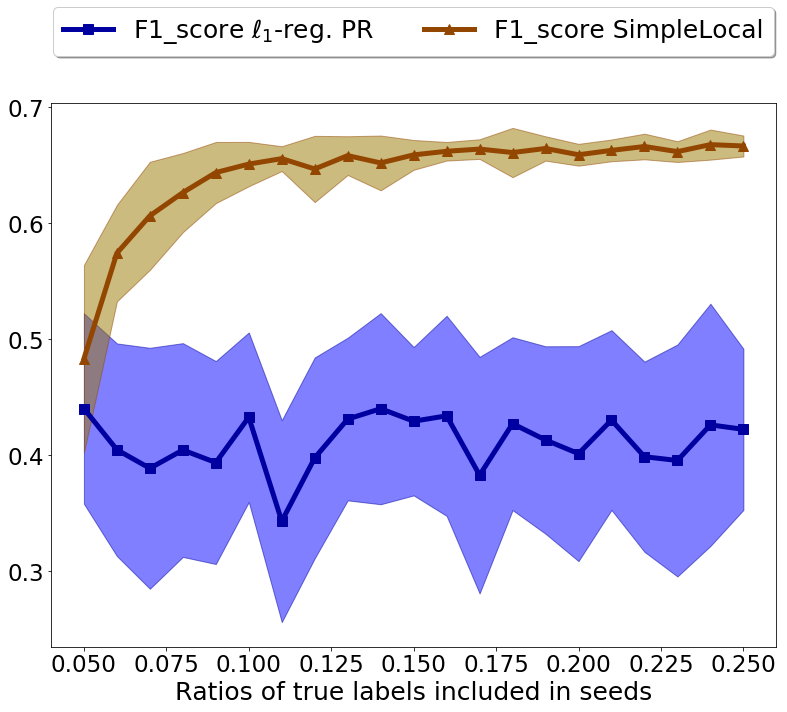

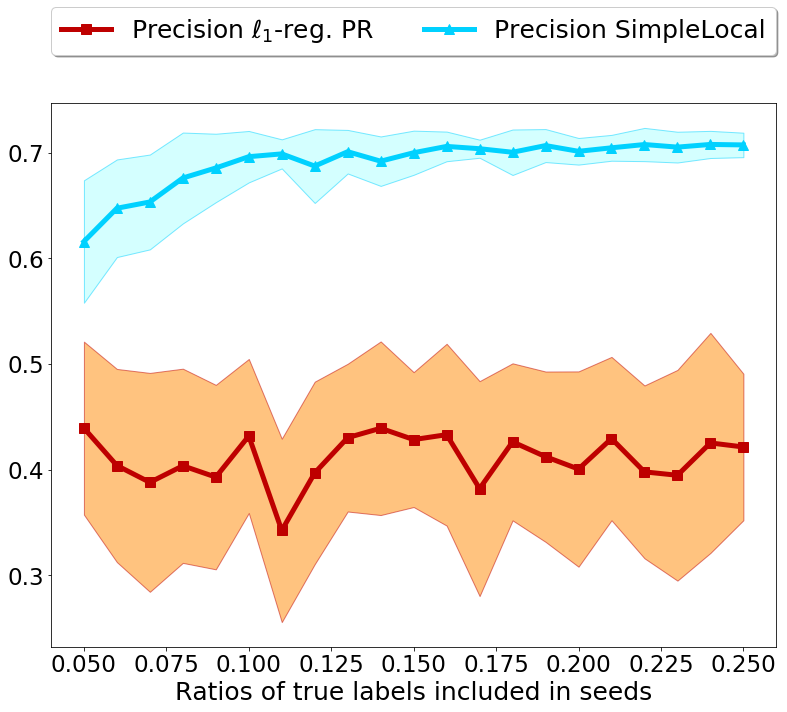

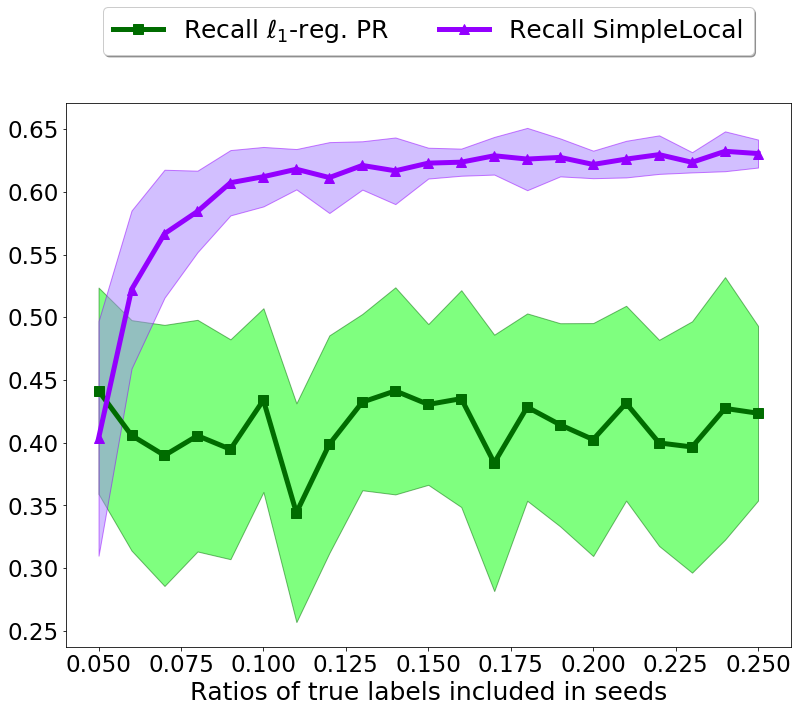

In [5]:
x = 0.01*np.array(range(5,26))
y1 = np.array([i[0] for i in records["l1reg_F1_all"]])
y2 = np.array([i[0] for i in records["flow_F1_all"]])
y3 = np.array([i[0] for i in records["l1reg_PR_all"]])
y4 = np.array([i[0] for i in records["flow_PR_all"]])
y5 = np.array([i[0] for i in records["l1reg_RC_all"]])
y6 = np.array([i[0] for i in records["flow_RC_all"]])
std1 = np.array([i[1] for i in records["l1reg_F1_all"]])
std2 = np.array([i[1] for i in records["flow_F1_all"]])
std3 = np.array([i[1] for i in records["l1reg_PR_all"]])
std4 = np.array([i[1] for i in records["flow_PR_all"]])
std5 = np.array([i[1] for i in records["l1reg_RC_all"]])
std6 = np.array([i[1] for i in records["flow_RC_all"]])

# Plot results
f = plt.figure(figsize=(13, 10))

plt.plot(x, y1, 'k', color='#0000A1', marker="s",markersize=10,linewidth=5)
plt.fill_between(x, y1-std1, y1+std1,
    alpha=0.5, edgecolor='#0000A1', facecolor='#0000FF')
plt.plot(x, y2, 'k', color='#934600', marker="^",markersize=10,linewidth=5)
plt.fill_between(x, y2-std2, y2+std2,
    alpha=0.5, edgecolor='#934600', facecolor='#9B7900')
#plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['F1_score $\ell_1$-reg. PR', 'F1_score SimpleLocal'], loc='upper center', fancybox=True, shadow=True ,
           bbox_to_anchor=(0.5, 1.2), ncol=2, fontsize=25)

plt.xlabel('Ratios of true labels included in seeds', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f.savefig("citeseer_f1_sl_without_l1reg.pdf",format='pdf',bbox_inches='tight')

f = plt.figure(figsize=(13, 10))

plt.plot(x, y3, 'k', color='#BE0000', marker="s",markersize=10,linewidth=5)
plt.fill_between(x, y3-std3, y3+std3,
    alpha=0.5, edgecolor='#BE0000', facecolor='#FF8800')
plt.plot(x, y4, 'k', color='#00D1FF', marker="^",markersize=10,linewidth=5)
plt.fill_between(x, y4-std4, y4+std4,
    alpha=0.5, edgecolor='#00D1FF', facecolor='#ABFFFF')
#plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['Precision $\ell_1$-reg. PR', 'Precision SimpleLocal'], loc='upper center', fancybox=True, shadow=True ,
           bbox_to_anchor=(0.5, 1.2), ncol=2, fontsize=25)

plt.xlabel('Ratios of true labels included in seeds', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f.savefig("citeseer_pr_sl_without_l1reg.pdf",format='pdf',bbox_inches='tight')

f = plt.figure(figsize=(13, 10))

plt.plot(x, y5, 'k', color='#006C00', marker="s",markersize=10,linewidth=5)
plt.fill_between(x, y5-std5, y5+std5,
    alpha=0.5, edgecolor='#006C00', facecolor='#00FF00')
plt.plot(x, y6, 'k', color='#9400FF', marker="^",markersize=10,linewidth=5)
plt.fill_between(x, y6-std6, y6+std6,
    alpha=0.5, edgecolor='#9400FF', facecolor='#A780FF')
#plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['Recall $\ell_1$-reg. PR', 'Recall SimpleLocal'], loc='upper center', fancybox=True, shadow=True ,
           bbox_to_anchor=(0.5, 1.2), ncol=2, fontsize=25)

plt.xlabel('Ratios of true labels included in seeds', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f.savefig("citeseer_rc_sl_without_l1reg.pdf",format='pdf',bbox_inches='tight')

## semi-supervised learning using subset of target cluster + BFS as seed nodes

In [6]:
kwargs_list = [{"method":"l1reg-rand",
                "alpha":0.1,
                "rho":1.0e-10,
                "normalize":False,
                "normalized_objective":False,
                "epsilon":1.0e-8,
                "iterations":100000,
                "cpp":True,
                "delta":0.01,
                "ratio":ratio} for ratio in 0.01*np.array(range(5,26))]

In [7]:
records1 = semisupervised_learning(g_copy,clusters_copy,kwargs_list,size_ratio=0.2,use_bfs=True,nprocs=40,flowmethod="mqi_weighted",use_spectral=False)
records2 = semisupervised_learning(g_copy,clusters_copy,kwargs_list,size_ratio=0.3,use_bfs=True,nprocs=40,flowmethod="mqi_weighted",use_spectral=False)
records3 = semisupervised_learning(g_copy,clusters_copy,kwargs_list,size_ratio=0.4,use_bfs=True,nprocs=40,flowmethod="mqi_weighted",use_spectral=False)

Finished 0/420 experiments.
Finished 10/420 experiments.
Finished 20/420 experiments.
Finished 30/420 experiments.
Finished 40/420 experiments.
Finished 50/420 experiments.
Finished 60/420 experiments.
Finished 70/420 experiments.
Finished 80/420 experiments.
Finished 90/420 experiments.
Finished 100/420 experiments.
Finished 110/420 experiments.
Finished 120/420 experiments.
Finished 130/420 experiments.
Finished 140/420 experiments.
Finished 150/420 experiments.
Finished 160/420 experiments.
Finished 170/420 experiments.
Finished 180/420 experiments.
Finished 190/420 experiments.
Finished 200/420 experiments.
Finished 210/420 experiments.
Finished 220/420 experiments.
Finished 230/420 experiments.
Finished 240/420 experiments.
Finished 250/420 experiments.
Finished 260/420 experiments.
Finished 270/420 experiments.
Finished 280/420 experiments.
Finished 290/420 experiments.
Finished 300/420 experiments.
Finished 310/420 experiments.
Finished 320/420 experiments.
Finished 330/420 expe

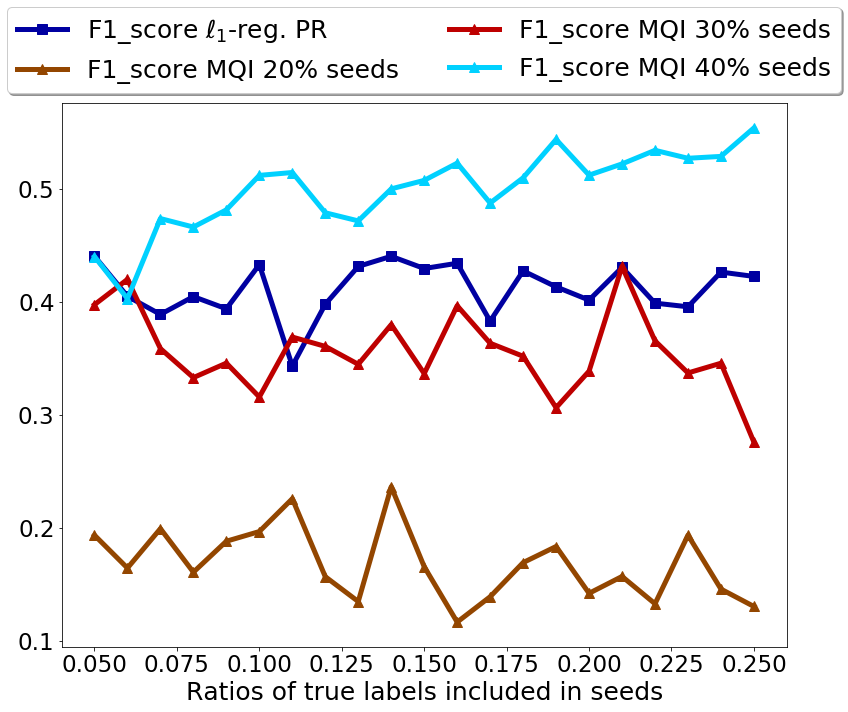

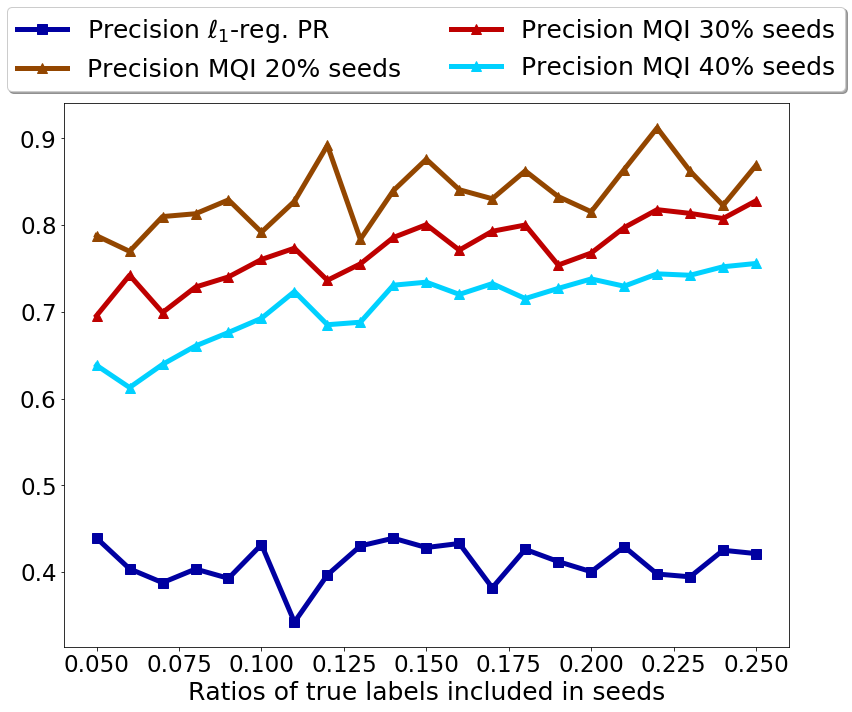

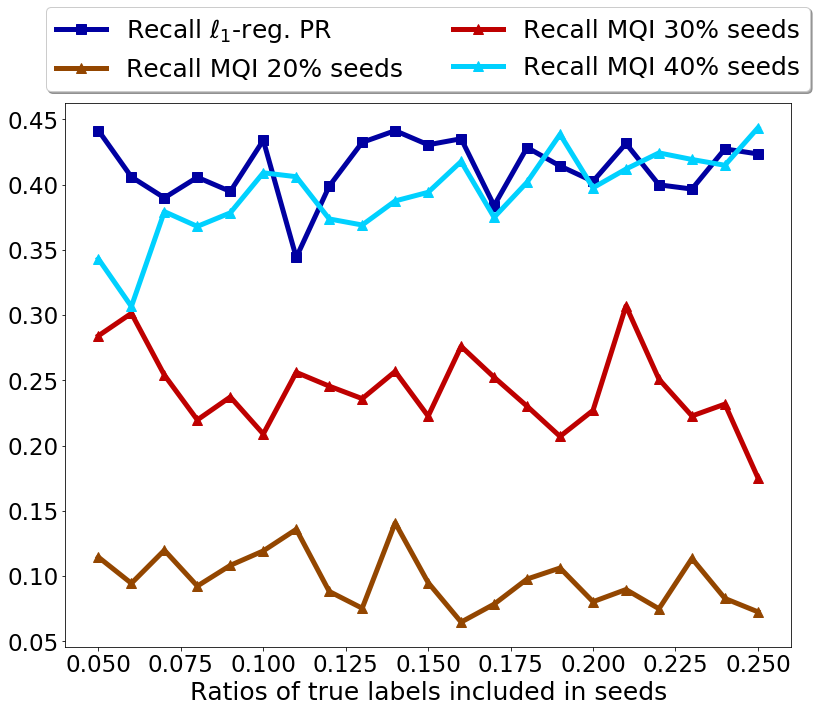

In [8]:
x = 0.01*np.array(range(5,26))

# Plot results
f = plt.figure(figsize=(13, 10))

y1 = np.array([i[0] for i in records["l1reg_F1_all"]])
y2 = np.array([i[0] for i in records1["flow_F1_all"]])
y3 = np.array([i[0] for i in records2["flow_F1_all"]])
y4 = np.array([i[0] for i in records3["flow_F1_all"]])
std1 = np.array([i[1] for i in records["l1reg_F1_all"]])
std2 = np.array([i[1] for i in records1["flow_F1_all"]])
std3 = np.array([i[1] for i in records2["flow_F1_all"]])
std4 = np.array([i[1] for i in records3["flow_F1_all"]])

plt.plot(x, y1, 'k', color='#0000A1', marker="s",markersize=10,linewidth=5)
# plt.fill_between(x, y1-std1, y1+std1,
#     alpha=0.5, edgecolor='#0000A1', facecolor='#0000FF')
plt.plot(x, y2, 'k', color='#934600', marker="^",markersize=10,linewidth=5)
# plt.fill_between(x, y2-std2, y2+std2,
#     alpha=0.5, edgecolor='#934600', facecolor='#9B7900')
plt.plot(x, y3, 'k', color='#BE0000', marker="^",markersize=10,linewidth=5)
# plt.fill_between(x, y3-std3, y3+std3,
#     alpha=0.5, edgecolor='#BE0000', facecolor='#FF8800')
plt.plot(x, y4, 'k', color='#00D1FF', marker="^",markersize=10,linewidth=5)
# plt.fill_between(x, y4-std4, y4+std4,
#     alpha=0.5, edgecolor='#00D1FF', facecolor='#ABFFFF')
#plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['F1_score $\ell_1$-reg. PR', 'F1_score MQI 20% seeds','F1_score MQI 30% seeds','F1_score MQI 40% seeds'], loc='upper center', bbox_to_anchor=(0.5, 1.2), 
           fancybox=True, shadow=True ,ncol=2,fontsize=25)

plt.xlabel('Ratios of true labels included in seeds', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f.savefig("citeseer_f1_sl_without_l1reg.pdf",format='pdf',bbox_inches='tight')

f = plt.figure(figsize=(13, 10))

y1 = np.array([i[0] for i in records["l1reg_PR_all"]])
y2 = np.array([i[0] for i in records1["flow_PR_all"]])
y3 = np.array([i[0] for i in records2["flow_PR_all"]])
y4 = np.array([i[0] for i in records3["flow_PR_all"]])
std1 = np.array([i[1] for i in records["l1reg_PR_all"]])
std2 = np.array([i[1] for i in records1["flow_PR_all"]])
std3 = np.array([i[1] for i in records2["flow_PR_all"]])
std4 = np.array([i[1] for i in records3["flow_PR_all"]])

plt.plot(x, y1, 'k', color='#0000A1', marker="s",markersize=10,linewidth=5)
# plt.fill_between(x, y1-std1, y1+std1,
#     alpha=0.5, edgecolor='#0000A1', facecolor='#0000FF')
plt.plot(x, y2, 'k', color='#934600', marker="^",markersize=10,linewidth=5)
# plt.fill_between(x, y2-std2, y2+std2,
#     alpha=0.5, edgecolor='#934600', facecolor='#9B7900')
plt.plot(x, y3, 'k', color='#BE0000', marker="^",markersize=10,linewidth=5)
# plt.fill_between(x, y3-std3, y3+std3,
#     alpha=0.5, edgecolor='#BE0000', facecolor='#FF8800')
plt.plot(x, y4, 'k', color='#00D1FF', marker="^",markersize=10,linewidth=5)
# plt.fill_between(x, y4-std4, y4+std4,
#     alpha=0.5, edgecolor='#00D1FF', facecolor='#ABFFFF')
#plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['Precision $\ell_1$-reg. PR', 'Precision MQI 20% seeds','Precision MQI 30% seeds','Precision MQI 40% seeds'], loc='upper center', bbox_to_anchor=(0.5, 1.2), 
           fancybox=True, shadow=True ,ncol=2,fontsize=25)

plt.xlabel('Ratios of true labels included in seeds', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f.savefig("citeseer_pr_sl_without_l1reg.pdf",format='pdf',bbox_inches='tight')

f = plt.figure(figsize=(13, 10))

y1 = np.array([i[0] for i in records["l1reg_RC_all"]])
y2 = np.array([i[0] for i in records1["flow_RC_all"]])
y3 = np.array([i[0] for i in records2["flow_RC_all"]])
y4 = np.array([i[0] for i in records3["flow_RC_all"]])
std1 = np.array([i[1] for i in records["l1reg_RC_all"]])
std2 = np.array([i[1] for i in records1["flow_RC_all"]])
std3 = np.array([i[1] for i in records2["flow_RC_all"]])
std4 = np.array([i[1] for i in records3["flow_RC_all"]])

plt.plot(x, y1, 'k', color='#0000A1', marker="s",markersize=10,linewidth=5)
# plt.fill_between(x, y1-std1, y1+std1,
#     alpha=0.5, edgecolor='#0000A1', facecolor='#0000FF')
plt.plot(x, y2, 'k', color='#934600', marker="^",markersize=10,linewidth=5)
# plt.fill_between(x, y2-std2, y2+std2,
#     alpha=0.5, edgecolor='#934600', facecolor='#9B7900')
plt.plot(x, y3, 'k', color='#BE0000', marker="^",markersize=10,linewidth=5)
# plt.fill_between(x, y3-std3, y3+std3,
#     alpha=0.5, edgecolor='#BE0000', facecolor='#FF8800')
plt.plot(x, y4, 'k', color='#00D1FF', marker="^",markersize=10,linewidth=5)
# plt.fill_between(x, y4-std4, y4+std4,
#     alpha=0.5, edgecolor='#00D1FF', facecolor='#ABFFFF')
#plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['Recall $\ell_1$-reg. PR', 'Recall MQI 20% seeds','Recall MQI 30% seeds','Recall MQI 40% seeds'], loc='upper center', bbox_to_anchor=(0.5, 1.2), 
           fancybox=True, shadow=True ,ncol=2,fontsize=25)

plt.xlabel('Ratios of true labels included in seeds', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f.savefig("citeseer_rc_sl_without_l1reg.pdf",format='pdf',bbox_inches='tight')

# Cora citation dataset

In [9]:
import sys
sys.path.append("../LocalGraphClustering/")
import localgraphclustering as lgc
from collections import Counter,defaultdict
import numpy as np

rptr = open("dataset/cora/cora.content","r")
lines = rptr.readlines()
rptr.close()

ids = {}
labels = {}
clusters = defaultdict(list)
nnodes = 0
for i,line in enumerate(lines):
    tmp = line.replace("\n","").split("\t")
    labels[i] = tmp[-1]
    ids[tmp[0]] = i
    nnodes += 1
    clusters[tmp[-1]].append(i)

rptr = open("dataset/cora/cora.cites","r")
lines = rptr.readlines()
rptr.close()

ei,ej = [],[]
for line in lines:
    tmp = line.replace("\n","").split("\t")
    if tmp[0] not in ids:
        ids[tmp[0]] = nnodes
        nnodes += 1
    if tmp[1] not in ids:
        ids[tmp[1]] = nnodes
        nnodes += 1
    ei.append(ids[tmp[0]])
    ej.append(ids[tmp[1]])

g = lgc.GraphLocal()
g.list_to_gl(ei,ej,[1.0]*len(ei))
g.connected_components()
largest_component= set(np.nonzero(g.components == Counter(g.components).most_common()[0][0])[0])
g_copy = g.largest_component()
clusters_copy = defaultdict(list)
nnodes = 0
for i in range(g._num_vertices):
    if i in largest_component:
        if i in labels:
            clusters_copy[labels[i]].append(nnodes)
        nnodes += 1

There are  78  connected components in the graph
There are  78  connected components in the graph


../LocalGraphClustering/localgraphclustering/GraphLocal.py:621: UserWarning:

The graph has multiple (78) components, using the largest with 2485 / 2708 nodes



## semi-supervised learning using subset of target cluster as seed nodes

In [10]:
kwargs_list = [{"method":"l1reg-rand",
                "alpha":0.1,
                "rho":1.0e-10,
                "normalize":False,
                "normalized_objective":False,
                "epsilon":1.0e-8,
                "iterations":100000,
                "cpp":True,
                "delta":0.01,
                "ratio":ratio} for ratio in 0.01*np.array(range(5,26))]

In [11]:
records = semisupervised_learning(g_copy,clusters_copy,kwargs_list,nprocs=40,flowmethod="sl")

Finished 0/420 experiments.
Finished 10/420 experiments.
Finished 20/420 experiments.
Finished 30/420 experiments.
Finished 40/420 experiments.
Finished 50/420 experiments.
Finished 60/420 experiments.
Finished 70/420 experiments.
Finished 80/420 experiments.
Finished 90/420 experiments.
Finished 100/420 experiments.
Finished 110/420 experiments.
Finished 120/420 experiments.
Finished 130/420 experiments.
Finished 140/420 experiments.
Finished 150/420 experiments.
Finished 160/420 experiments.
Finished 170/420 experiments.
Finished 180/420 experiments.
Finished 190/420 experiments.
Finished 200/420 experiments.
Finished 210/420 experiments.
Finished 220/420 experiments.
Finished 230/420 experiments.
Finished 240/420 experiments.
Finished 250/420 experiments.
Finished 260/420 experiments.
Finished 270/420 experiments.
Finished 280/420 experiments.
Finished 290/420 experiments.
Finished 300/420 experiments.
Finished 310/420 experiments.
Finished 320/420 experiments.
Finished 330/420 expe

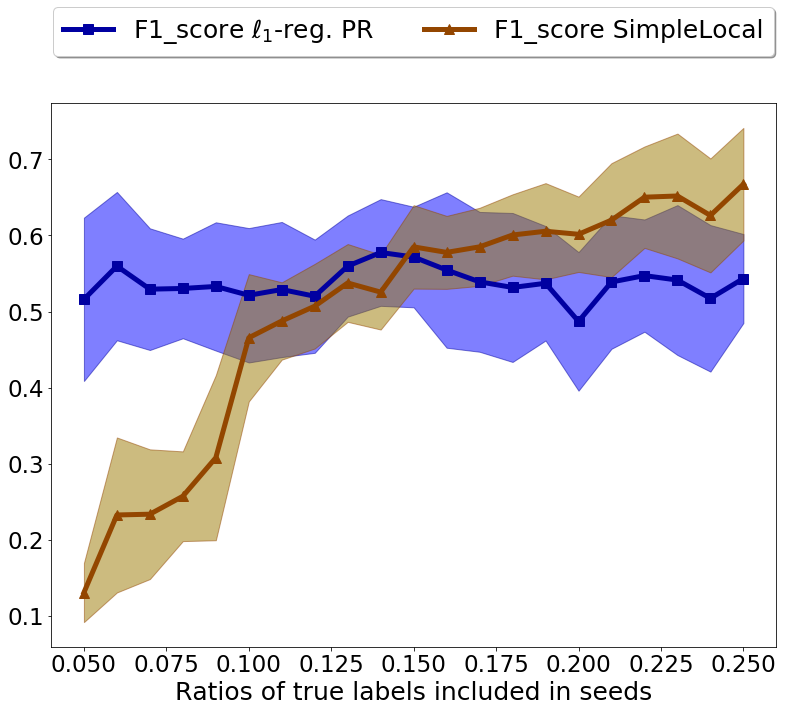

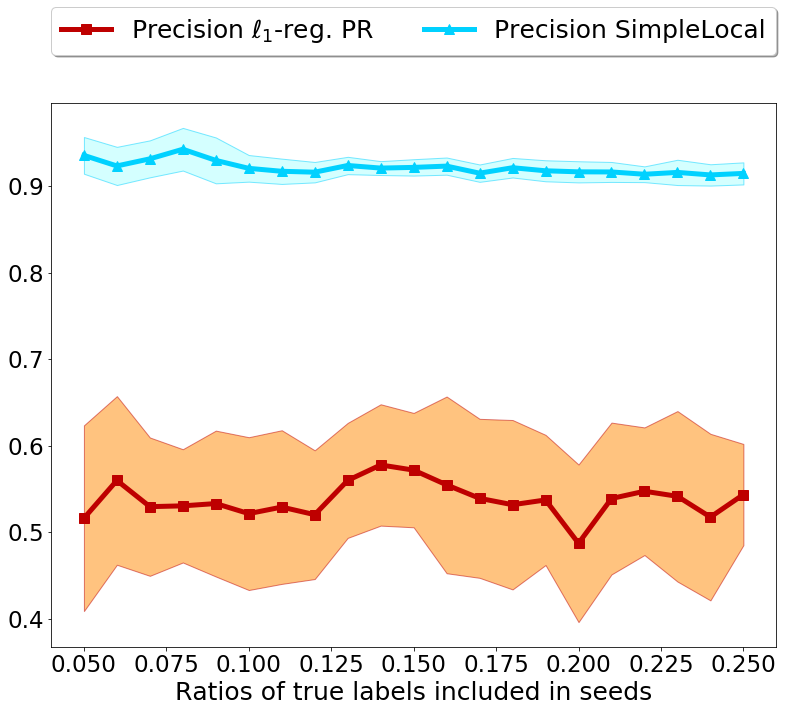

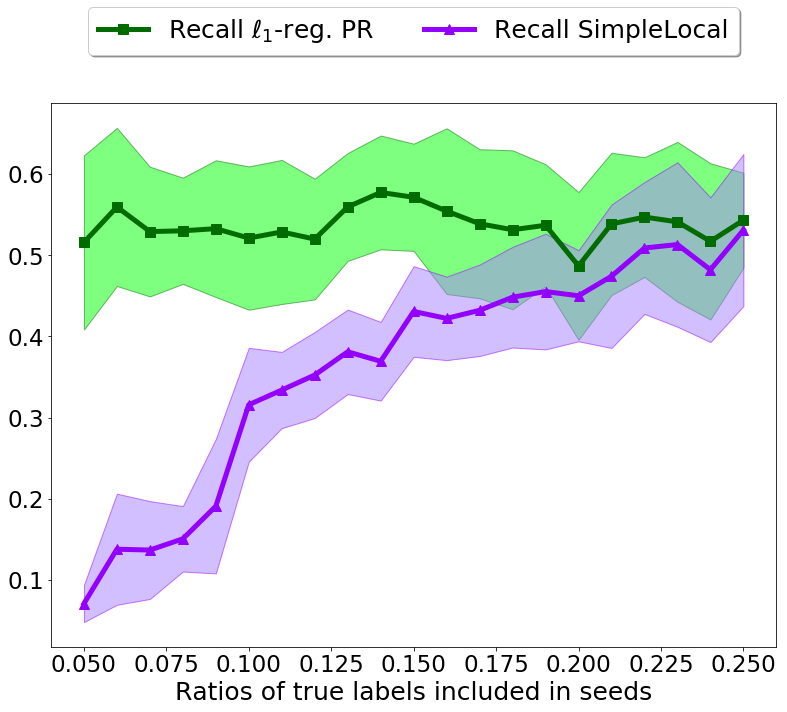

In [12]:
x = 0.01*np.array(range(5,26))
y1 = np.array([i[0] for i in records["l1reg_F1_all"]])
y2 = np.array([i[0] for i in records["flow_F1_all"]])
y3 = np.array([i[0] for i in records["l1reg_PR_all"]])
y4 = np.array([i[0] for i in records["flow_PR_all"]])
y5 = np.array([i[0] for i in records["l1reg_RC_all"]])
y6 = np.array([i[0] for i in records["flow_RC_all"]])
std1 = np.array([i[1] for i in records["l1reg_F1_all"]])
std2 = np.array([i[1] for i in records["flow_F1_all"]])
std3 = np.array([i[1] for i in records["l1reg_PR_all"]])
std4 = np.array([i[1] for i in records["flow_PR_all"]])
std5 = np.array([i[1] for i in records["l1reg_RC_all"]])
std6 = np.array([i[1] for i in records["flow_RC_all"]])


# Plot results
f = plt.figure(figsize=(13, 10))

plt.plot(x, y1, 'k', color='#0000A1', marker="s",markersize=10,linewidth=5)
plt.fill_between(x, y1-std1, y1+std1,
    alpha=0.5, edgecolor='#0000A1', facecolor='#0000FF')
plt.plot(x, y2, 'k', color='#934600', marker="^",markersize=10,linewidth=5)
plt.fill_between(x, y2-std2, y2+std2,
    alpha=0.5, edgecolor='#934600', facecolor='#9B7900')
#plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['F1_score $\ell_1$-reg. PR', 'F1_score SimpleLocal'], loc='upper center', fancybox=True, shadow=True ,
           bbox_to_anchor=(0.5, 1.2), ncol=2, fontsize=25)

plt.xlabel('Ratios of true labels included in seeds', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f.savefig("cora_f1_sl_without_l1reg.pdf",format='pdf',bbox_inches='tight')

f = plt.figure(figsize=(13, 10))

plt.plot(x, y3, 'k', color='#BE0000', marker="s",markersize=10,linewidth=5)
plt.fill_between(x, y3-std3, y3+std3,
    alpha=0.5, edgecolor='#BE0000', facecolor='#FF8800')
plt.plot(x, y4, 'k', color='#00D1FF', marker="^",markersize=10,linewidth=5)
plt.fill_between(x, y4-std4, y4+std4,
    alpha=0.5, edgecolor='#00D1FF', facecolor='#ABFFFF')
#plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['Precision $\ell_1$-reg. PR', 'Precision SimpleLocal'], loc='upper center', fancybox=True, shadow=True ,
           bbox_to_anchor=(0.5, 1.2), ncol=2, fontsize=25)

plt.xlabel('Ratios of true labels included in seeds', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f.savefig("cora_pr_sl_without_l1reg.pdf",format='pdf',bbox_inches='tight')

f = plt.figure(figsize=(13, 10))

plt.plot(x, y5, 'k', color='#006C00', marker="s",markersize=10,linewidth=5)
plt.fill_between(x, y5-std5, y5+std5,
    alpha=0.5, edgecolor='#006C00', facecolor='#00FF00')
plt.plot(x, y6, 'k', color='#9400FF', marker="^",markersize=10,linewidth=5)
plt.fill_between(x, y6-std6, y6+std6,
    alpha=0.5, edgecolor='#9400FF', facecolor='#A780FF')
#plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['Recall $\ell_1$-reg. PR', 'Recall SimpleLocal'], loc='upper center', fancybox=True, shadow=True ,
           bbox_to_anchor=(0.5, 1.2), ncol=2, fontsize=25)

plt.xlabel('Ratios of true labels included in seeds', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f.savefig("cora_rc_sl_without_l1reg.pdf",format='pdf',bbox_inches='tight')

## semi-supervised learning using subset of target cluster + BFS as seed nodes

In [13]:
kwargs_list = [{"method":"l1reg-rand",
                "alpha":0.1,
                "rho":1.0e-10,
                "normalize":False,
                "normalized_objective":False,
                "epsilon":1.0e-8,
                "iterations":100000,
                "cpp":True,
                "delta":0.01,
                "ratio":ratio} for ratio in 0.01*np.array(range(5,26))]

In [14]:
records1 = semisupervised_learning(g_copy,clusters_copy,kwargs_list,size_ratio=0.1,use_bfs=True,nprocs=40,flowmethod="mqi",use_spectral=False)
records2 = semisupervised_learning(g_copy,clusters_copy,kwargs_list,size_ratio=0.15,use_bfs=True,nprocs=40,flowmethod="mqi",use_spectral=False)
records3 = semisupervised_learning(g_copy,clusters_copy,kwargs_list,size_ratio=0.2,use_bfs=True,nprocs=40,flowmethod="mqi",use_spectral=False)

Finished 0/420 experiments.
Finished 10/420 experiments.
Finished 20/420 experiments.
Finished 30/420 experiments.
Finished 40/420 experiments.
Finished 50/420 experiments.
Finished 60/420 experiments.
Finished 70/420 experiments.
Finished 80/420 experiments.
Finished 90/420 experiments.
Finished 100/420 experiments.
Finished 110/420 experiments.
Finished 120/420 experiments.
Finished 130/420 experiments.
Finished 140/420 experiments.
Finished 150/420 experiments.
Finished 160/420 experiments.
Finished 170/420 experiments.
Finished 180/420 experiments.
Finished 190/420 experiments.
Finished 200/420 experiments.
Finished 210/420 experiments.
Finished 220/420 experiments.
Finished 230/420 experiments.
Finished 240/420 experiments.
Finished 250/420 experiments.
Finished 260/420 experiments.
Finished 270/420 experiments.
Finished 280/420 experiments.
Finished 290/420 experiments.
Finished 300/420 experiments.
Finished 310/420 experiments.
Finished 320/420 experiments.
Finished 330/420 expe

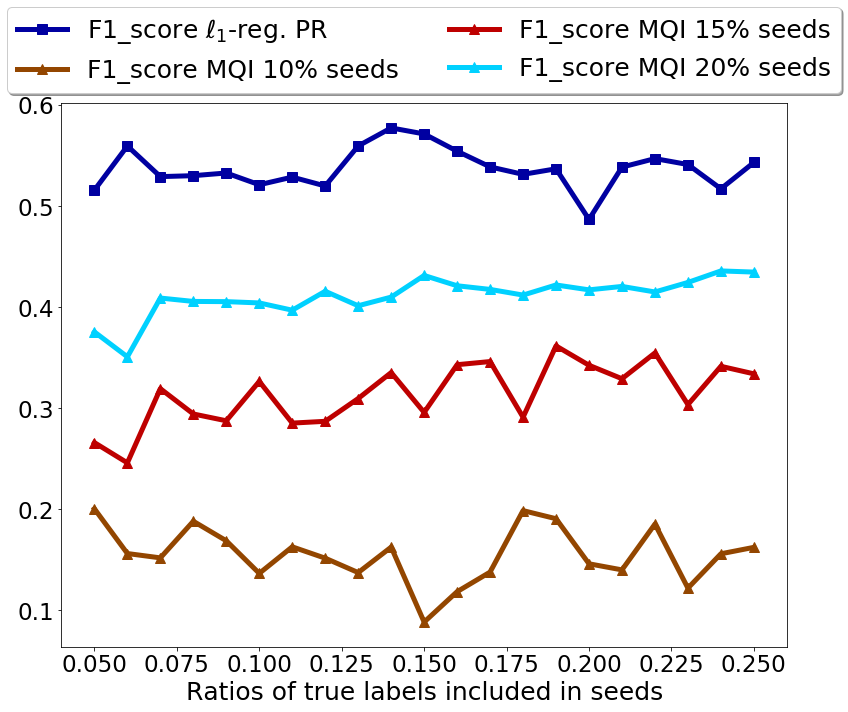

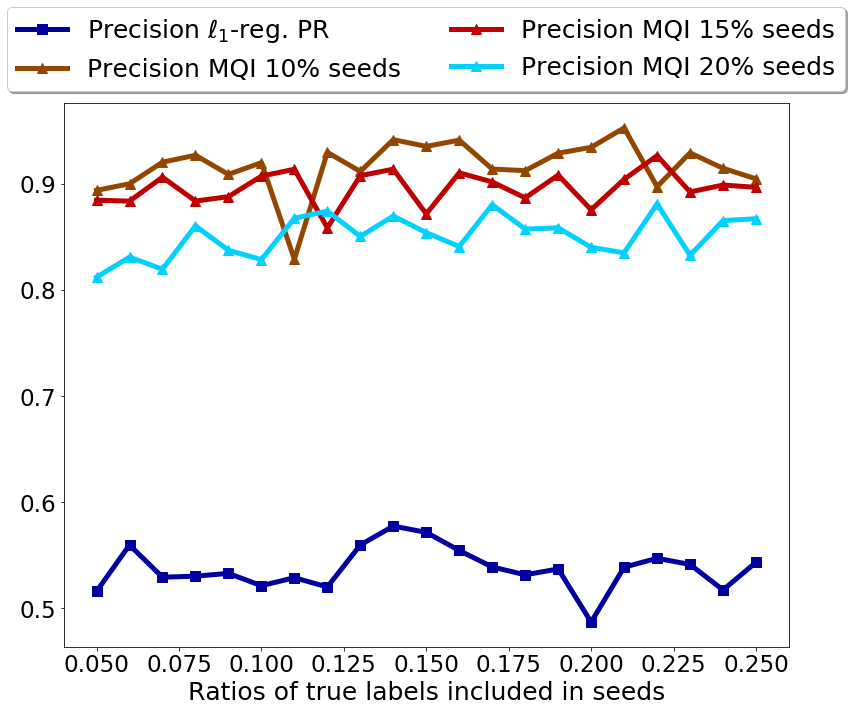

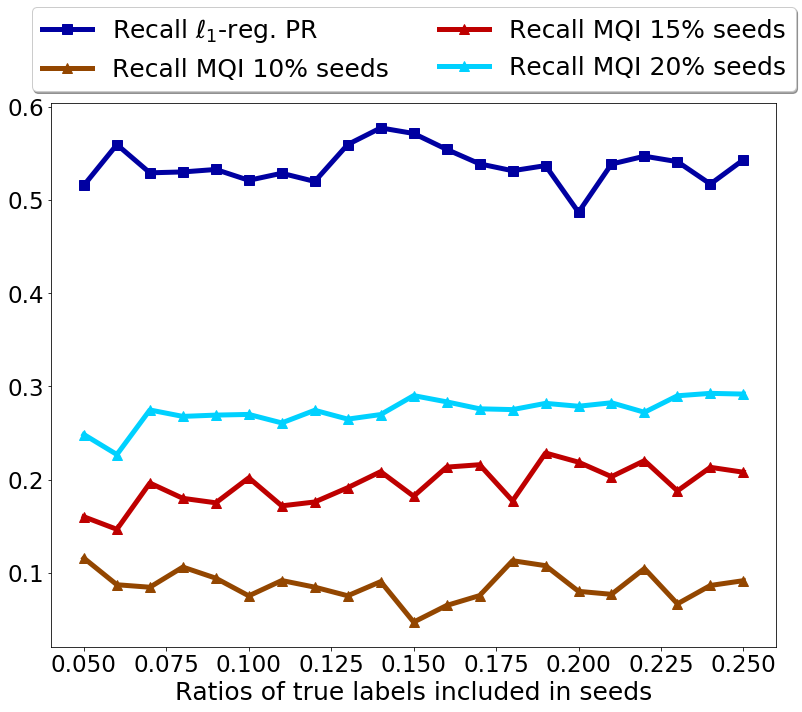

In [15]:
x = 0.01*np.array(range(5,26))

# Plot results
f = plt.figure(figsize=(13, 10))

y1 = np.array([i[0] for i in records["l1reg_F1_all"]])
y2 = np.array([i[0] for i in records1["flow_F1_all"]])
y3 = np.array([i[0] for i in records2["flow_F1_all"]])
y4 = np.array([i[0] for i in records3["flow_F1_all"]])
std1 = np.array([i[1] for i in records["l1reg_F1_all"]])
std2 = np.array([i[1] for i in records1["flow_F1_all"]])
std3 = np.array([i[1] for i in records2["flow_F1_all"]])
std4 = np.array([i[1] for i in records3["flow_F1_all"]])

plt.plot(x, y1, 'k', color='#0000A1', marker="s",markersize=10,linewidth=5)
# plt.fill_between(x, y1-std1, y1+std1,
#     alpha=0.5, edgecolor='#0000A1', facecolor='#0000FF')
plt.plot(x, y2, 'k', color='#934600', marker="^",markersize=10,linewidth=5)
# plt.fill_between(x, y2-std2, y2+std2,
#     alpha=0.5, edgecolor='#934600', facecolor='#9B7900')
plt.plot(x, y3, 'k', color='#BE0000', marker="^",markersize=10,linewidth=5)
# plt.fill_between(x, y3-std3, y3+std3,
#     alpha=0.5, edgecolor='#BE0000', facecolor='#FF8800')
plt.plot(x, y4, 'k', color='#00D1FF', marker="^",markersize=10,linewidth=5)
# plt.fill_between(x, y4-std4, y4+std4,
#     alpha=0.5, edgecolor='#00D1FF', facecolor='#ABFFFF')
#plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['F1_score $\ell_1$-reg. PR', 'F1_score MQI 10% seeds','F1_score MQI 15% seeds','F1_score MQI 20% seeds'], loc='upper center', bbox_to_anchor=(0.5, 1.2), 
           fancybox=True, shadow=True ,ncol=2,fontsize=25)

plt.xlabel('Ratios of true labels included in seeds', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f.savefig("citeseer_f1_sl_without_l1reg.pdf",format='pdf',bbox_inches='tight')

f = plt.figure(figsize=(13, 10))

y1 = np.array([i[0] for i in records["l1reg_PR_all"]])
y2 = np.array([i[0] for i in records1["flow_PR_all"]])
y3 = np.array([i[0] for i in records2["flow_PR_all"]])
y4 = np.array([i[0] for i in records3["flow_PR_all"]])
std1 = np.array([i[1] for i in records["l1reg_PR_all"]])
std2 = np.array([i[1] for i in records1["flow_PR_all"]])
std3 = np.array([i[1] for i in records2["flow_PR_all"]])
std4 = np.array([i[1] for i in records3["flow_PR_all"]])

plt.plot(x, y1, 'k', color='#0000A1', marker="s",markersize=10,linewidth=5)
# plt.fill_between(x, y1-std1, y1+std1,
#     alpha=0.5, edgecolor='#0000A1', facecolor='#0000FF')
plt.plot(x, y2, 'k', color='#934600', marker="^",markersize=10,linewidth=5)
# plt.fill_between(x, y2-std2, y2+std2,
#     alpha=0.5, edgecolor='#934600', facecolor='#9B7900')
plt.plot(x, y3, 'k', color='#BE0000', marker="^",markersize=10,linewidth=5)
# plt.fill_between(x, y3-std3, y3+std3,
#     alpha=0.5, edgecolor='#BE0000', facecolor='#FF8800')
plt.plot(x, y4, 'k', color='#00D1FF', marker="^",markersize=10,linewidth=5)
# plt.fill_between(x, y4-std4, y4+std4,
#     alpha=0.5, edgecolor='#00D1FF', facecolor='#ABFFFF')
#plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['Precision $\ell_1$-reg. PR', 'Precision MQI 10% seeds','Precision MQI 15% seeds','Precision MQI 20% seeds'], loc='upper center', bbox_to_anchor=(0.5, 1.2), 
           fancybox=True, shadow=True ,ncol=2,fontsize=25)

plt.xlabel('Ratios of true labels included in seeds', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f.savefig("citeseer_pr_sl_without_l1reg.pdf",format='pdf',bbox_inches='tight')

f = plt.figure(figsize=(13, 10))

y1 = np.array([i[0] for i in records["l1reg_RC_all"]])
y2 = np.array([i[0] for i in records1["flow_RC_all"]])
y3 = np.array([i[0] for i in records2["flow_RC_all"]])
y4 = np.array([i[0] for i in records3["flow_RC_all"]])
std1 = np.array([i[1] for i in records["l1reg_RC_all"]])
std2 = np.array([i[1] for i in records1["flow_RC_all"]])
std3 = np.array([i[1] for i in records2["flow_RC_all"]])
std4 = np.array([i[1] for i in records3["flow_RC_all"]])

plt.plot(x, y1, 'k', color='#0000A1', marker="s",markersize=10,linewidth=5)
# plt.fill_between(x, y1-std1, y1+std1,
#     alpha=0.5, edgecolor='#0000A1', facecolor='#0000FF')
plt.plot(x, y2, 'k', color='#934600', marker="^",markersize=10,linewidth=5)
# plt.fill_between(x, y2-std2, y2+std2,
#     alpha=0.5, edgecolor='#934600', facecolor='#9B7900')
plt.plot(x, y3, 'k', color='#BE0000', marker="^",markersize=10,linewidth=5)
# plt.fill_between(x, y3-std3, y3+std3,
#     alpha=0.5, edgecolor='#BE0000', facecolor='#FF8800')
plt.plot(x, y4, 'k', color='#00D1FF', marker="^",markersize=10,linewidth=5)
# plt.fill_between(x, y4-std4, y4+std4,
#     alpha=0.5, edgecolor='#00D1FF', facecolor='#ABFFFF')
#plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['Recall $\ell_1$-reg. PR', 'Recall MQI 10% seeds','Recall MQI 15% seeds','Recall MQI 20% seeds'], loc='upper center', bbox_to_anchor=(0.5, 1.2), 
           fancybox=True, shadow=True ,ncol=2,fontsize=25)

plt.xlabel('Ratios of true labels included in seeds', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f.savefig("citeseer_rc_sl_without_l1reg.pdf",format='pdf',bbox_inches='tight')

# MNIST knn network

In [16]:
import numpy as np
import mnist
import scipy.misc

images = mnist.train_images()
labels = mnist.train_labels()

In [17]:
image_data = np.zeros((images.shape[0],images.shape[1]*images.shape[2]),dtype=np.float32)

In [18]:
for i,im in enumerate(images):
    image_data[i,:] = (im.astype("float32")/255).flatten()

In [19]:
# from sklearn.neighbors import kneighbors_graph
# knn = kneighbors_graph(image_data,100,n_jobs=40,mode='distance')
# import scipy.sparse as sp

# A = sp.csr_matrix(knn)
# sel = A.T > A
# A = A - A.multiply(sel) + A.T.multiply(sel)
# A.data = np.exp(-0.5*(A.data**2))

In [20]:
# wptr = open("dataset/MNIST_100_knn.p","wb")
# pickle.dump(A,wptr)
# wptr.close()

In [21]:
import pickle
import scipy.sparse as sp
rptr = open("dataset/MNIST_100_knn.p","rb")
A = pickle.load(rptr)
rptr.close()

A = A.multiply(A>1.0e-6)
A.eliminate_zeros()

In [22]:
g = lgc.GraphLocal.from_sparse_adjacency(A)
clusters = defaultdict(list)
for i,l in enumerate(labels):
    clusters[l].append(i)
g.connected_components()
largest_component= set(np.nonzero(g.components == Counter(g.components).most_common()[0][0])[0])
g_copy = g.largest_component()
clusters_copy = defaultdict(list)
nnodes = 0
for i in range(g._num_vertices):
    if i in largest_component:
        clusters_copy[labels[i]].append(nnodes)
        nnodes += 1

There are  11291  connected components in the graph
There are  11291  connected components in the graph


../LocalGraphClustering/localgraphclustering/GraphLocal.py:621: UserWarning:

The graph has multiple (11291) components, using the largest with 47490 / 60000 nodes



## semi-supervised learning using subset of target cluster as seed nodes

In [23]:
kwargs_list = [{"method":"l1reg-rand",
                "alpha":0.1,
                "rho":1.0e-5,
                "normalize":False,
                "normalized_objective":False,
                "epsilon":1.0e-3,
                "iterations":10000,
                "cpp":True,
                "delta":0.01,
                "ratio":ratio} for ratio in 0.01*np.array(range(5,26))]

In [24]:
records = semisupervised_learning(g_copy,clusters_copy,kwargs_list,nprocs=80,flowmethod="sl_weighted")
# wptr = open("MNIST_ssl_sl.p","wb")
# pickle.dump(records,wptr)
# wptr.close()

Finished 0/420 experiments.
Finished 10/420 experiments.
Finished 20/420 experiments.
Finished 30/420 experiments.
Finished 40/420 experiments.
Finished 50/420 experiments.
Finished 60/420 experiments.
Finished 70/420 experiments.
Finished 80/420 experiments.
Finished 90/420 experiments.
Finished 100/420 experiments.
Finished 110/420 experiments.
Finished 120/420 experiments.
Finished 130/420 experiments.
Finished 140/420 experiments.
Finished 150/420 experiments.
Finished 160/420 experiments.
Finished 170/420 experiments.
Finished 180/420 experiments.
Finished 190/420 experiments.
Finished 200/420 experiments.
Finished 210/420 experiments.
Finished 220/420 experiments.
Finished 230/420 experiments.
Finished 240/420 experiments.
Finished 250/420 experiments.
Finished 260/420 experiments.
Finished 270/420 experiments.
Finished 280/420 experiments.
Finished 290/420 experiments.
Finished 300/420 experiments.
Finished 310/420 experiments.
Finished 320/420 experiments.
Finished 330/420 expe

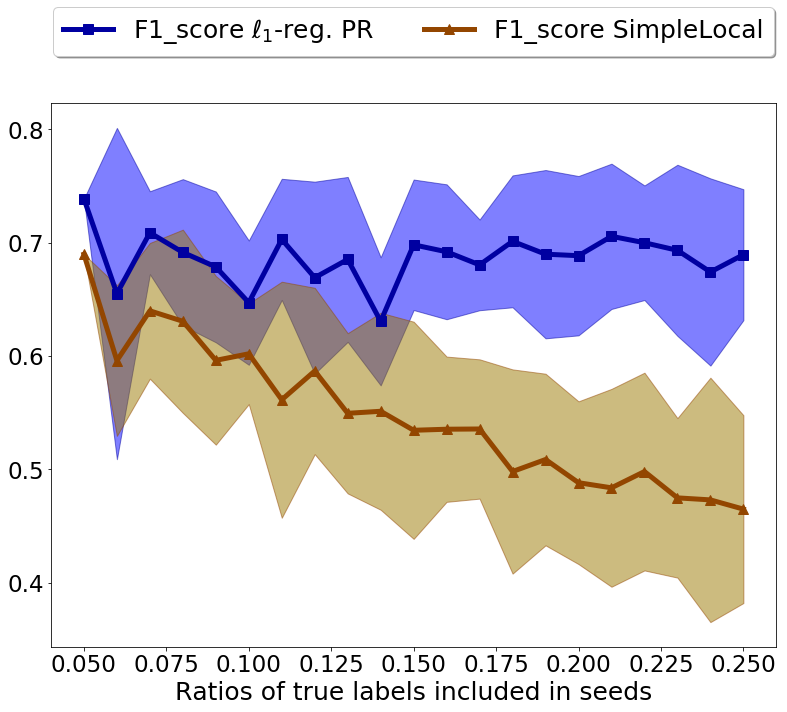

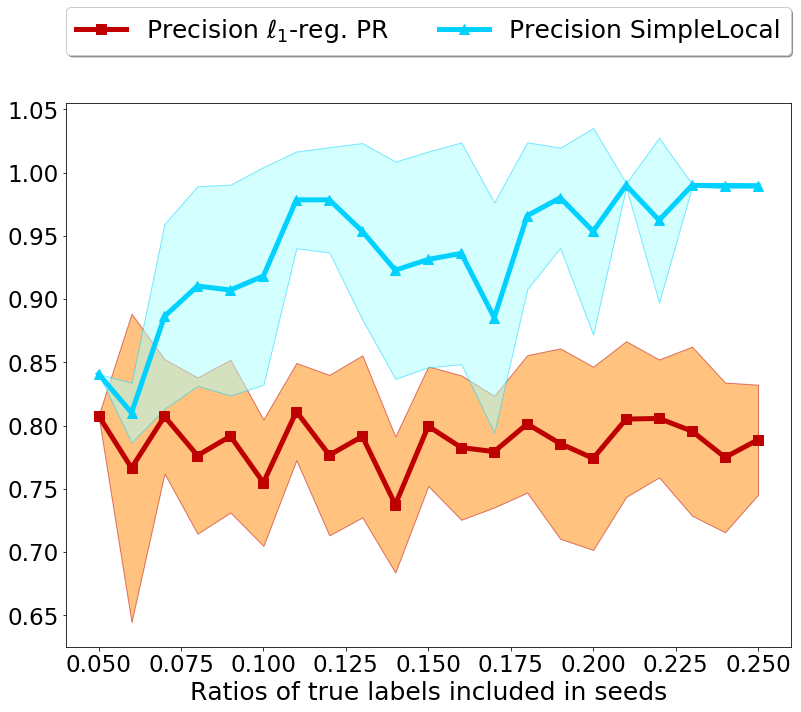

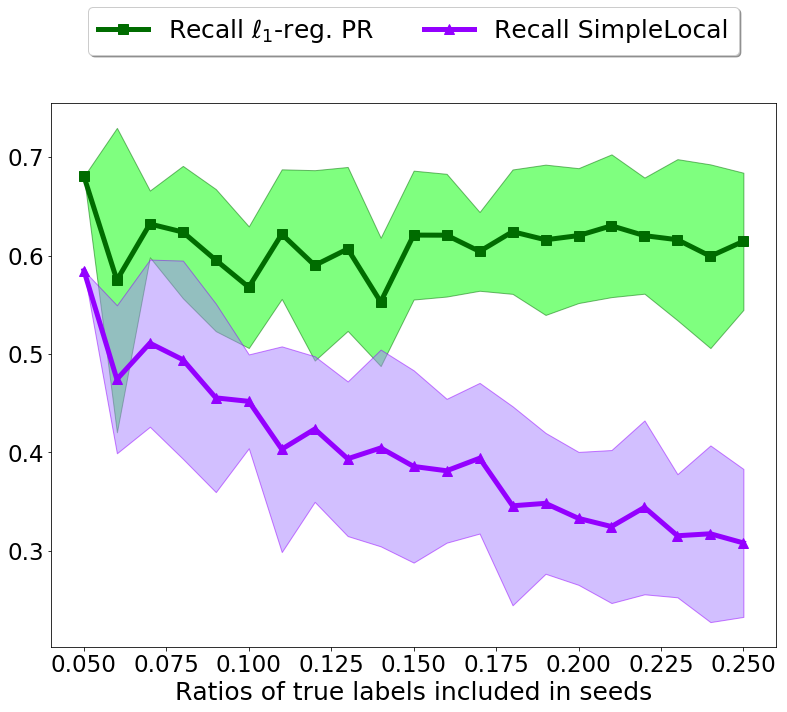

In [25]:
x = 0.01*np.array(range(5,26))
y1 = np.array([i[0] for i in records["l1reg_F1_all"]])
y2 = np.array([i[0] for i in records["flow_F1_all"]])
y3 = np.array([i[0] for i in records["l1reg_PR_all"]])
y4 = np.array([i[0] for i in records["flow_PR_all"]])
y5 = np.array([i[0] for i in records["l1reg_RC_all"]])
y6 = np.array([i[0] for i in records["flow_RC_all"]])
std1 = np.array([i[1] for i in records["l1reg_F1_all"]])
std2 = np.array([i[1] for i in records["flow_F1_all"]])
std3 = np.array([i[1] for i in records["l1reg_PR_all"]])
std4 = np.array([i[1] for i in records["flow_PR_all"]])
std5 = np.array([i[1] for i in records["l1reg_RC_all"]])
std6 = np.array([i[1] for i in records["flow_RC_all"]])

# Plot results
f = plt.figure(figsize=(13, 10))

plt.plot(x, y1, 'k', color='#0000A1', marker="s",markersize=10,linewidth=5)
plt.fill_between(x, y1-std1, y1+std1,
    alpha=0.5, edgecolor='#0000A1', facecolor='#0000FF')
plt.plot(x, y2, 'k', color='#934600', marker="^",markersize=10,linewidth=5)
plt.fill_between(x, y2-std2, y2+std2,
    alpha=0.5, edgecolor='#934600', facecolor='#9B7900')
#plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['F1_score $\ell_1$-reg. PR', 'F1_score SimpleLocal'], loc='upper center', fancybox=True, shadow=True ,
           bbox_to_anchor=(0.5, 1.2), ncol=2, fontsize=25)

plt.xlabel('Ratios of true labels included in seeds', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f.savefig("mnist_f1_sl_without_l1reg.pdf",format='pdf',bbox_inches='tight')

f = plt.figure(figsize=(13, 10))

plt.plot(x, y3, 'k', color='#BE0000', marker="s",markersize=10,linewidth=5)
plt.fill_between(x, y3-std3, y3+std3,
    alpha=0.5, edgecolor='#BE0000', facecolor='#FF8800')
plt.plot(x, y4, 'k', color='#00D1FF', marker="^",markersize=10,linewidth=5)
plt.fill_between(x, y4-std4, y4+std4,
    alpha=0.5, edgecolor='#00D1FF', facecolor='#ABFFFF')
#plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['Precision $\ell_1$-reg. PR', 'Precision SimpleLocal'], loc='upper center', fancybox=True, shadow=True ,
           bbox_to_anchor=(0.5, 1.2), ncol=2, fontsize=25)

plt.xlabel('Ratios of true labels included in seeds', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f.savefig("mnist_pr_sl_without_l1reg.pdf",format='pdf',bbox_inches='tight')

f = plt.figure(figsize=(13, 10))

plt.plot(x, y5, 'k', color='#006C00', marker="s",markersize=10,linewidth=5)
plt.fill_between(x, y5-std5, y5+std5,
    alpha=0.5, edgecolor='#006C00', facecolor='#00FF00')
plt.plot(x, y6, 'k', color='#9400FF', marker="^",markersize=10,linewidth=5)
plt.fill_between(x, y6-std6, y6+std6,
    alpha=0.5, edgecolor='#9400FF', facecolor='#A780FF')
#plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['Recall $\ell_1$-reg. PR', 'Recall SimpleLocal'], loc='upper center', fancybox=True, shadow=True ,
           bbox_to_anchor=(0.5, 1.2), ncol=2, fontsize=25)

plt.xlabel('Ratios of true labels included in seeds', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f.savefig("mnist_rc_sl_without_l1reg.pdf",format='pdf',bbox_inches='tight')

## semi-supervised learning using subset of target cluster + BFS as seed nodes

In [26]:
kwargs_list = [{"method":"l1reg-rand",
                "alpha":0.1,
                "rho":1.0e-5,
                "normalize":False,
                "normalized_objective":False,
                "epsilon":1.0e-3,
                "iterations":10000,
                "cpp":True,
                "delta":0.1,
                "ratio":ratio} for ratio in 0.01*np.array(range(5,26))]

In [27]:
records1 = semisupervised_learning(g_copy,clusters_copy,kwargs_list,size_ratio=0.1,use_bfs=True,nprocs=80,flowmethod="mqi_weighted",use_spectral=False)
records2 = semisupervised_learning(g_copy,clusters_copy,kwargs_list,size_ratio=0.15,use_bfs=True,nprocs=80,flowmethod="mqi_weighted",use_spectral=False)
records3 = semisupervised_learning(g_copy,clusters_copy,kwargs_list,size_ratio=0.2,use_bfs=True,nprocs=80,flowmethod="mqi_weighted",use_spectral=False)

Finished 0/420 experiments.
Finished 10/420 experiments.
Finished 20/420 experiments.
Finished 30/420 experiments.
Finished 40/420 experiments.
Finished 50/420 experiments.
Finished 60/420 experiments.
Finished 70/420 experiments.
Finished 80/420 experiments.
Finished 90/420 experiments.
Finished 100/420 experiments.
Finished 110/420 experiments.
Finished 120/420 experiments.
Finished 130/420 experiments.
Finished 140/420 experiments.
Finished 150/420 experiments.
Finished 160/420 experiments.
Finished 170/420 experiments.
Finished 180/420 experiments.
Finished 190/420 experiments.
Finished 200/420 experiments.
Finished 210/420 experiments.
Finished 220/420 experiments.
Finished 230/420 experiments.
Finished 240/420 experiments.
Finished 250/420 experiments.
Finished 260/420 experiments.
Finished 270/420 experiments.
Finished 280/420 experiments.
Finished 290/420 experiments.
Finished 300/420 experiments.
Finished 310/420 experiments.
Finished 320/420 experiments.
Finished 330/420 expe

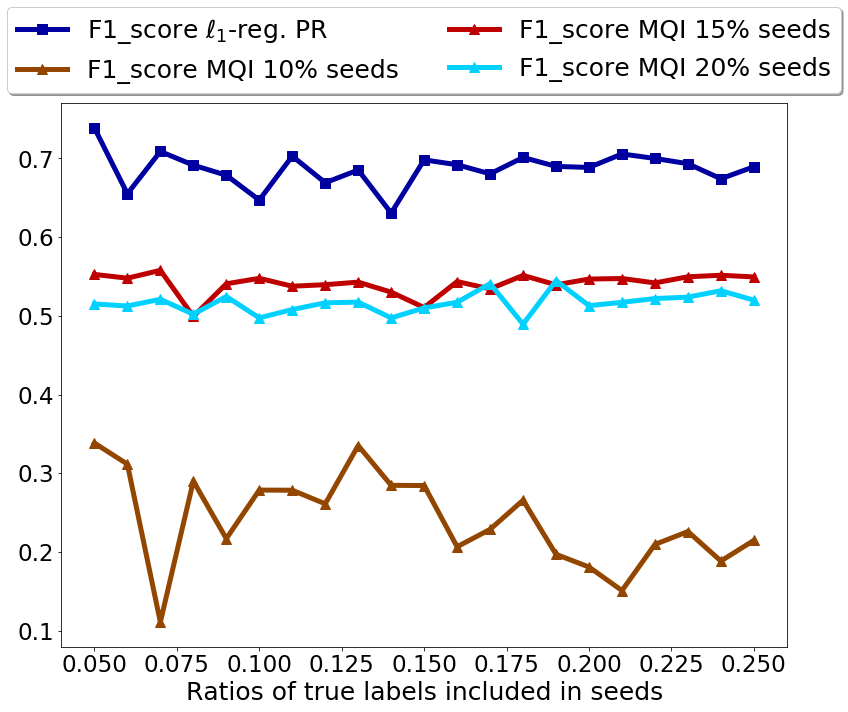

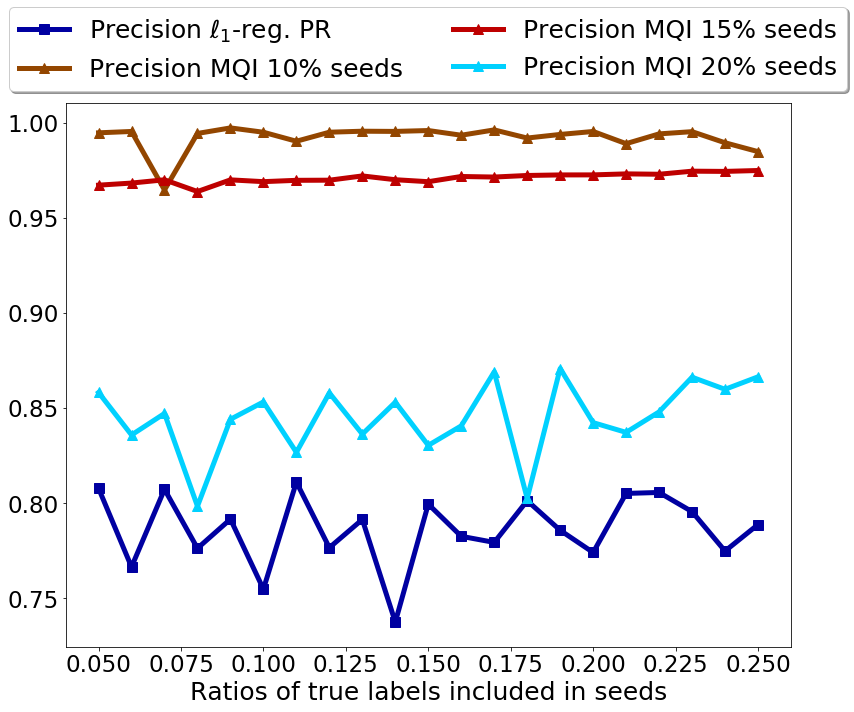

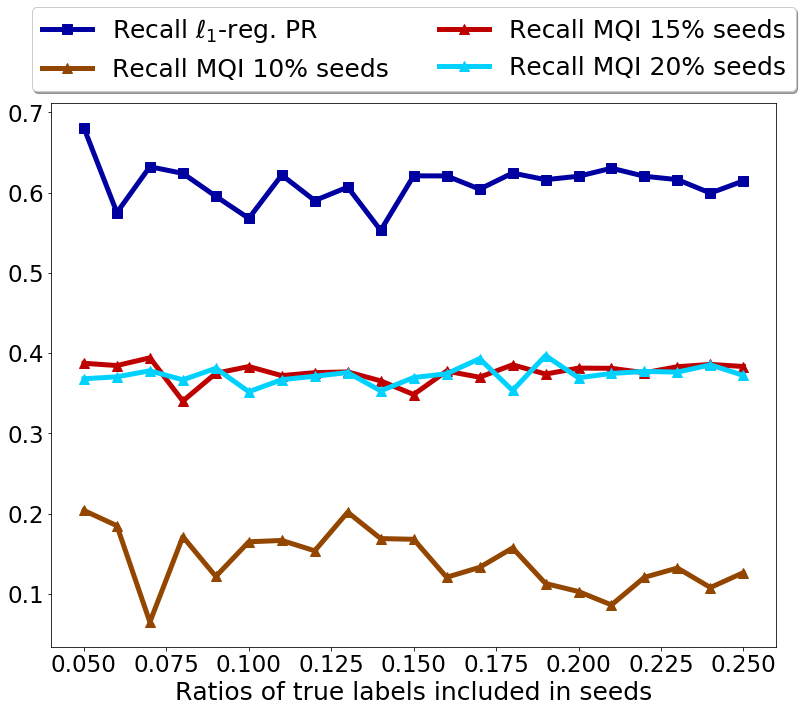

In [28]:
x = 0.01*np.array(range(5,26))

# Plot results
f = plt.figure(figsize=(13, 10))

y1 = np.array([i[0] for i in records["l1reg_F1_all"]])
y2 = np.array([i[0] for i in records1["flow_F1_all"]])
y3 = np.array([i[0] for i in records2["flow_F1_all"]])
y4 = np.array([i[0] for i in records3["flow_F1_all"]])
std1 = np.array([i[1] for i in records["l1reg_F1_all"]])
std2 = np.array([i[1] for i in records1["flow_F1_all"]])
std3 = np.array([i[1] for i in records2["flow_F1_all"]])
std4 = np.array([i[1] for i in records3["flow_F1_all"]])

plt.plot(x, y1, 'k', color='#0000A1', marker="s",markersize=10,linewidth=5)
# plt.fill_between(x, y1-std1, y1+std1,
#     alpha=0.5, edgecolor='#0000A1', facecolor='#0000FF')
plt.plot(x, y2, 'k', color='#934600', marker="^",markersize=10,linewidth=5)
# plt.fill_between(x, y2-std2, y2+std2,
#     alpha=0.5, edgecolor='#934600', facecolor='#9B7900')
plt.plot(x, y3, 'k', color='#BE0000', marker="^",markersize=10,linewidth=5)
# plt.fill_between(x, y3-std3, y3+std3,
#     alpha=0.5, edgecolor='#BE0000', facecolor='#FF8800')
plt.plot(x, y4, 'k', color='#00D1FF', marker="^",markersize=10,linewidth=5)
# plt.fill_between(x, y4-std4, y4+std4,
#     alpha=0.5, edgecolor='#00D1FF', facecolor='#ABFFFF')
#plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['F1_score $\ell_1$-reg. PR', 'F1_score MQI 10% seeds','F1_score MQI 15% seeds','F1_score MQI 20% seeds'], loc='upper center', bbox_to_anchor=(0.5, 1.2), 
           fancybox=True, shadow=True ,ncol=2,fontsize=25)

plt.xlabel('Ratios of true labels included in seeds', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f.savefig("citeseer_f1_sl_without_l1reg.pdf",format='pdf',bbox_inches='tight')

f = plt.figure(figsize=(13, 10))

y1 = np.array([i[0] for i in records["l1reg_PR_all"]])
y2 = np.array([i[0] for i in records1["flow_PR_all"]])
y3 = np.array([i[0] for i in records2["flow_PR_all"]])
y4 = np.array([i[0] for i in records3["flow_PR_all"]])
std1 = np.array([i[1] for i in records["l1reg_PR_all"]])
std2 = np.array([i[1] for i in records1["flow_PR_all"]])
std3 = np.array([i[1] for i in records2["flow_PR_all"]])
std4 = np.array([i[1] for i in records3["flow_PR_all"]])

plt.plot(x, y1, 'k', color='#0000A1', marker="s",markersize=10,linewidth=5)
# plt.fill_between(x, y1-std1, y1+std1,
#     alpha=0.5, edgecolor='#0000A1', facecolor='#0000FF')
plt.plot(x, y2, 'k', color='#934600', marker="^",markersize=10,linewidth=5)
# plt.fill_between(x, y2-std2, y2+std2,
#     alpha=0.5, edgecolor='#934600', facecolor='#9B7900')
plt.plot(x, y3, 'k', color='#BE0000', marker="^",markersize=10,linewidth=5)
# plt.fill_between(x, y3-std3, y3+std3,
#     alpha=0.5, edgecolor='#BE0000', facecolor='#FF8800')
plt.plot(x, y4, 'k', color='#00D1FF', marker="^",markersize=10,linewidth=5)
# plt.fill_between(x, y4-std4, y4+std4,
#     alpha=0.5, edgecolor='#00D1FF', facecolor='#ABFFFF')
#plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['Precision $\ell_1$-reg. PR', 'Precision MQI 10% seeds','Precision MQI 15% seeds','Precision MQI 20% seeds'], loc='upper center', bbox_to_anchor=(0.5, 1.2), 
           fancybox=True, shadow=True ,ncol=2,fontsize=25)

plt.xlabel('Ratios of true labels included in seeds', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f.savefig("citeseer_pr_sl_without_l1reg.pdf",format='pdf',bbox_inches='tight')

f = plt.figure(figsize=(13, 10))

y1 = np.array([i[0] for i in records["l1reg_RC_all"]])
y2 = np.array([i[0] for i in records1["flow_RC_all"]])
y3 = np.array([i[0] for i in records2["flow_RC_all"]])
y4 = np.array([i[0] for i in records3["flow_RC_all"]])
std1 = np.array([i[1] for i in records["l1reg_RC_all"]])
std2 = np.array([i[1] for i in records1["flow_RC_all"]])
std3 = np.array([i[1] for i in records2["flow_RC_all"]])
std4 = np.array([i[1] for i in records3["flow_RC_all"]])

plt.plot(x, y1, 'k', color='#0000A1', marker="s",markersize=10,linewidth=5)
# plt.fill_between(x, y1-std1, y1+std1,
#     alpha=0.5, edgecolor='#0000A1', facecolor='#0000FF')
plt.plot(x, y2, 'k', color='#934600', marker="^",markersize=10,linewidth=5)
# plt.fill_between(x, y2-std2, y2+std2,
#     alpha=0.5, edgecolor='#934600', facecolor='#9B7900')
plt.plot(x, y3, 'k', color='#BE0000', marker="^",markersize=10,linewidth=5)
# plt.fill_between(x, y3-std3, y3+std3,
#     alpha=0.5, edgecolor='#BE0000', facecolor='#FF8800')
plt.plot(x, y4, 'k', color='#00D1FF', marker="^",markersize=10,linewidth=5)
# plt.fill_between(x, y4-std4, y4+std4,
#     alpha=0.5, edgecolor='#00D1FF', facecolor='#ABFFFF')
#plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['Recall $\ell_1$-reg. PR', 'Recall MQI 10% seeds','Recall MQI 15% seeds','Recall MQI 20% seeds'], loc='upper center', bbox_to_anchor=(0.5, 1.2), 
           fancybox=True, shadow=True ,ncol=2,fontsize=25)

plt.xlabel('Ratios of true labels included in seeds', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f.savefig("citeseer_rc_sl_without_l1reg.pdf",format='pdf',bbox_inches='tight')

In [29]:
wptr = open("MNIST_ssl_sl1.p","wb")
pickle.dump(records1,wptr)
wptr.close()
wptr = open("MNIST_ssl_sl2.p","wb")
pickle.dump(records2,wptr)
wptr.close()
wptr = open("MNIST_ssl_sl3.p","wb")
pickle.dump(records3,wptr)
wptr.close()